In [1]:
%matplotlib inline
#
import sys; sys.path.insert(0, "..")
from multifunbrain import *
#
if '_dir_changed' not in globals():
    path_root = Path.cwd().parent
path_data =  path_root / Path("data")
path_atlas_timecourses = path_data / Path("atlas_timecourses")
path_correlation_matrices = path_data / Path("correlation_matrices")
path_neuroplots = path_data / Path("neuroplots")
#
if '_dir_changed' not in globals():
    os.chdir(path_root)
    _dir_changed = True
print(f"Current working directory: {Path.cwd()}")

Current working directory: /home/opisthofulax/Documents/UniPa/projects/multifun-brain


In [2]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr50-2mm', data_dir=path_data)
atlas_filename = atlas.maps
atlas_img = image.load_img(atlas_filename)
atlas_data = atlas_img.get_fdata()
#
rois = atlas.labels
rois_label_map = {i: ll for i,ll in enumerate(rois[1:])}
roi_indices = np.unique(list(rois_label_map.keys()))
#
template = load_mni152_template()

[get_dataset_dir] Dataset found in /home/opisthofulax/Documents/UniPa/projects/multifun-brain/data/fsl


In [21]:
contrast_keys = ["CBF_ASL", "CBV_VASO", "BOLD", "BOLD_RS"]
contrast_suffix = ["CBF4D", "fcurN_Vaso", "furN_Bold", "optcomMIRDenoised_bold"]
sampling_frequency_vals = [1/5.5, 1/1.353, 1/1.353, 1/0.98]
#
file_names_dict = {dk: f"corrcoeff_special_imf_cumul_{i}.pkl"
                   for i,dk,in enumerate(contrast_keys)}
sampling_frequency_dict = {dk: fs 
                           for dk, fs in zip(contrast_keys, sampling_frequency_vals)}
contrast_dict = {dk: dict(
    file_name=file_names_dict[dk], 
    freq=sampling_frequency_dict[dk])
    for dk in contrast_keys 
}

In [23]:
corr_matrices = {}
for dk in contrast_keys:
    file_name = contrast_dict[dk]['file_name']
    try:
        with open(path_correlation_matrices / file_name, 'rb') as f:
            corr_matrices[dk] = pickle.load(f)
    except:
        print(f"Could not load {file_name} correlation matrix file.")
        continue


Could not load corrcoeff_special_imf_cumul_0.pkl correlation matrix file.


In [36]:
dk = contrast_keys[3]
graph_threshold = 0.1
pinf_threshold = 1-0.01
corr_arr = corr_matrices[dk]

In [37]:
dk

'BOLD_RS'

In [38]:
del contrast_dict['CBF_ASL']

KeyError: 'CBF_ASL'

x value at crossing: 0.2693085556816239


/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/UniPa/projects/multifun-brain/notebooks/../multifunbrain/lrglib.py:53: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


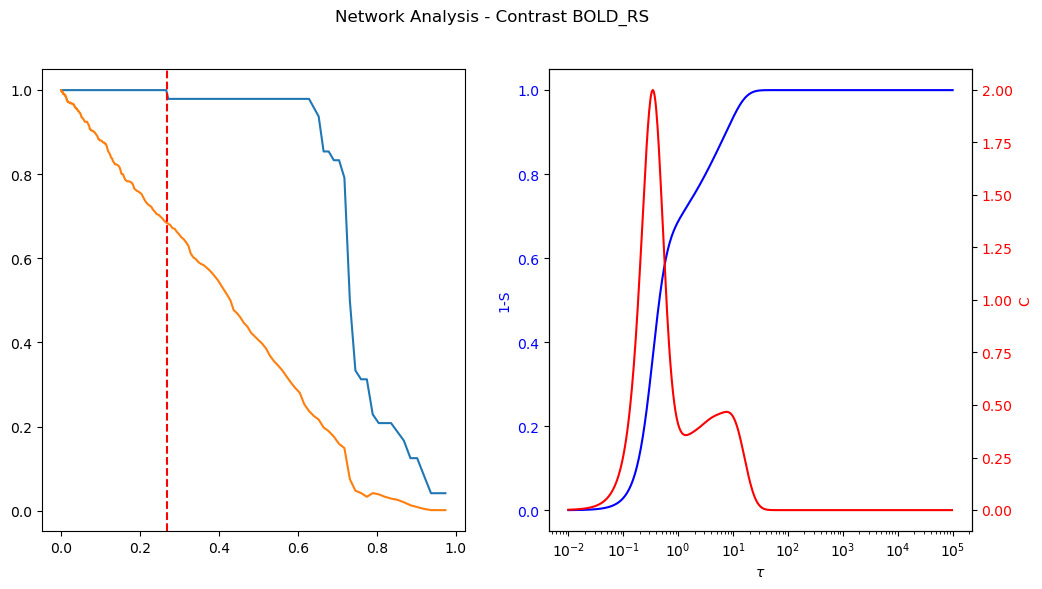

In [39]:
G, _ = build_correlation_network(corr_arr)
Th, Einf, Pinf = compute_threshold_stats(G)
cross_idx = np.where((Pinf[:-1] >= pinf_threshold) & (Pinf[1:] < pinf_threshold))[0]
if cross_idx.size > 0:
    i = cross_idx[0]
    x_cross = Th[i] + (Th[i+1] - Th[i]) * (Pinf[i] - pinf_threshold) / (Pinf[i] - Pinf[i+1])
    print("x value at crossing:", x_cross)
else:
    print("No crossing found.")
G, removednodes = build_correlation_network(corr_arr, threshold=max(float(x_cross), graph_threshold))
L = nx.laplacian_matrix(G).todense()
spectrum = nx.laplacian_spectrum(G)
rho_m = lambda tau: rho_matrix(tau, L)
Sm1, Csp, VarL, t = entropy(spectrum)
#
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pos = nx.kamada_kawai_layout(G)
# nx.draw(G, pos=pos, ax=ax[0], alpha=0.7, with_labels=True)
ax[0].plot(Th, Pinf, label="Pinf")
ax[0].plot(Th, Einf, label="Pinf")
ax[0].axvline(x=max(float(x_cross), graph_threshold), color='red', linestyle='--', label="x_cross")
plot_entropy_and_C(ax[1], t, Sm1, Csp, color1="blue", color2="red")
fig.suptitle(f"Network Analysis - Contrast {dk}")
fig.savefig(path_neuroplots / f"netan_{dk}.png", bbox_inches='tight')
# plt.close('all')

In [40]:
#
dists = symmetrized_inverse_distance(1/max(spectrum), rho_m)
linkage_matrix, label_list, tmax = compute_normalized_linkage(dists, G, method='ward')
merge_distances = linkage_matrix[:, 2]
tmin = linkage_matrix[::, 2][0] - 0.5*linkage_matrix[::, 2][0]

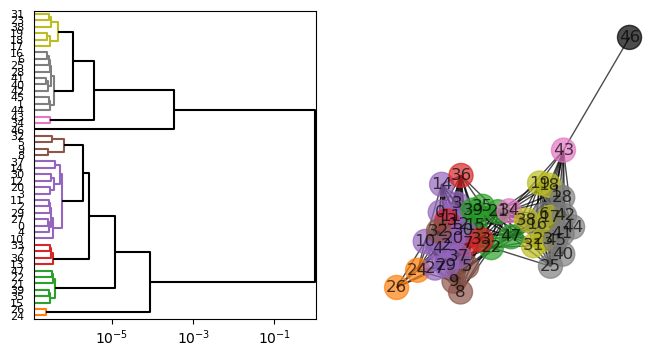

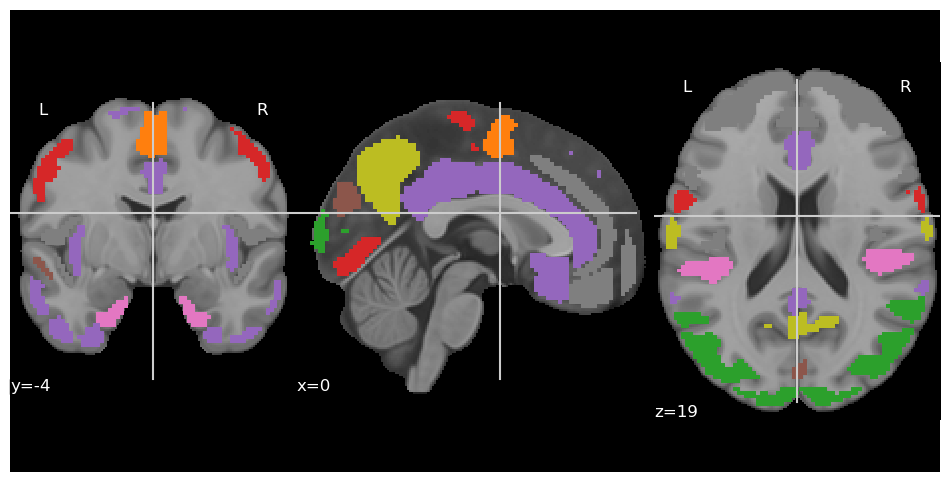

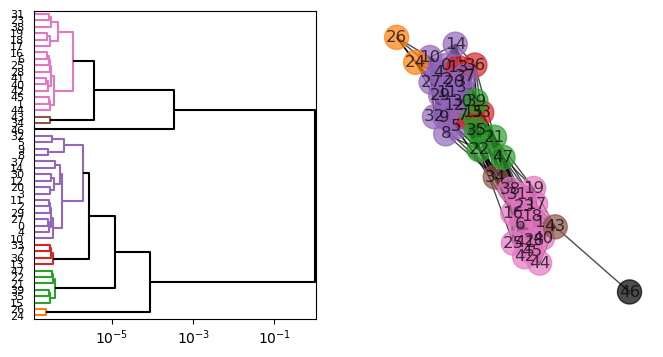

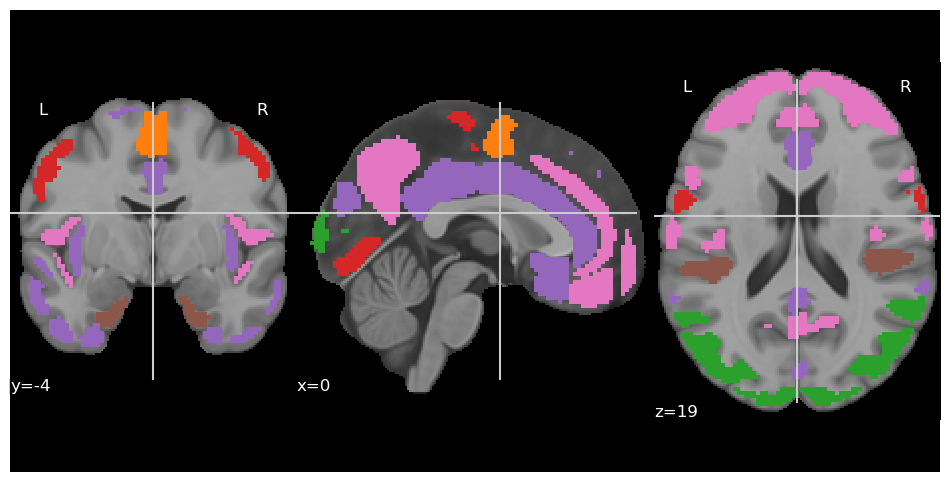

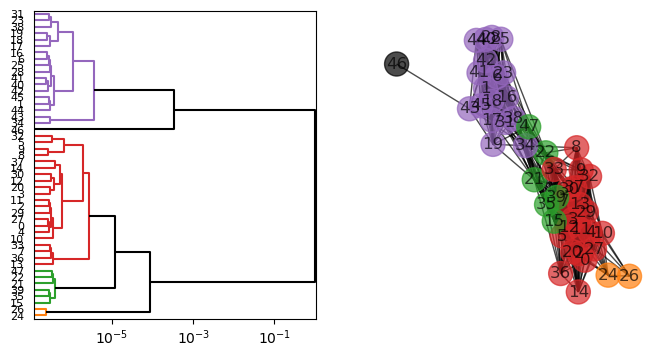

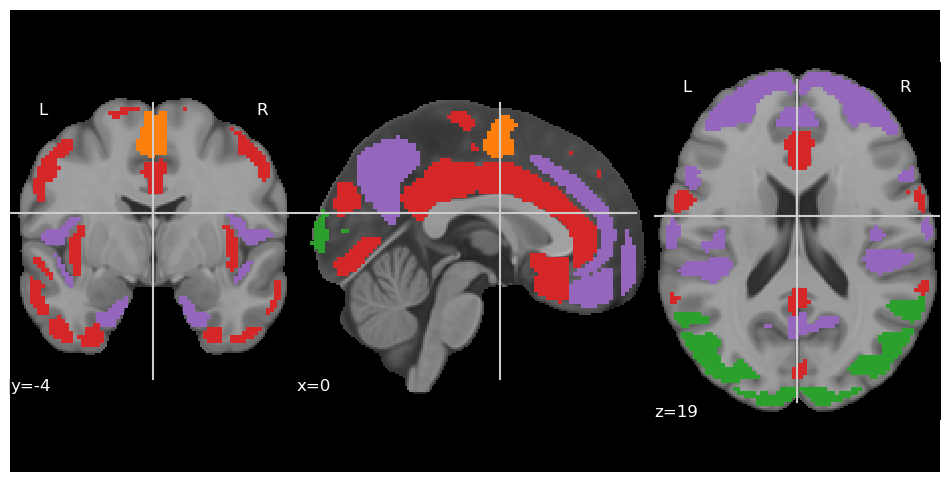

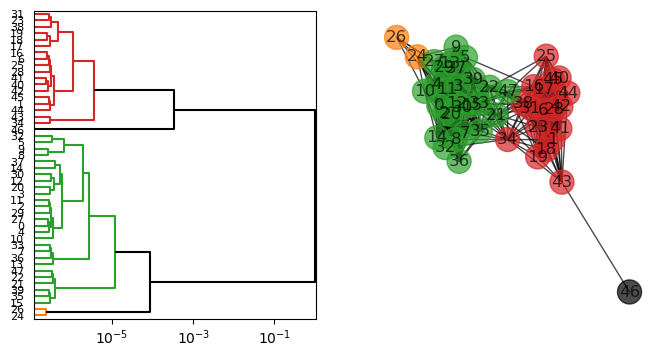

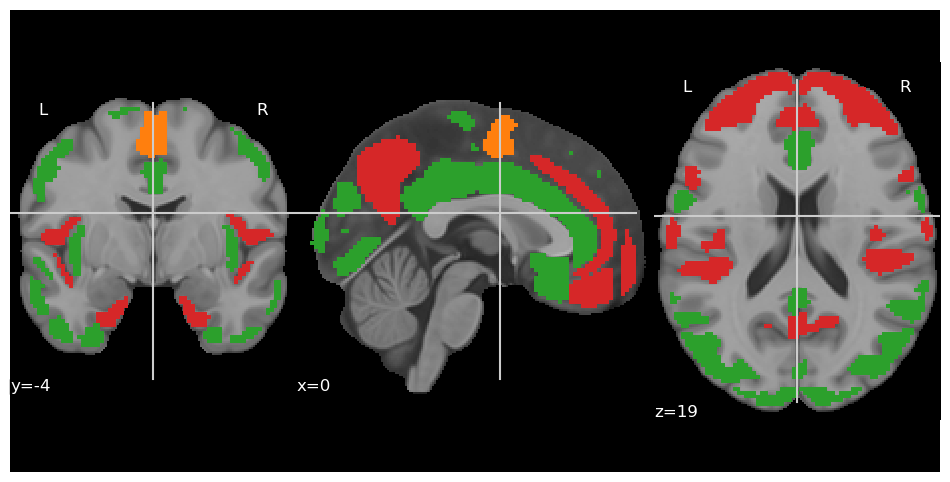

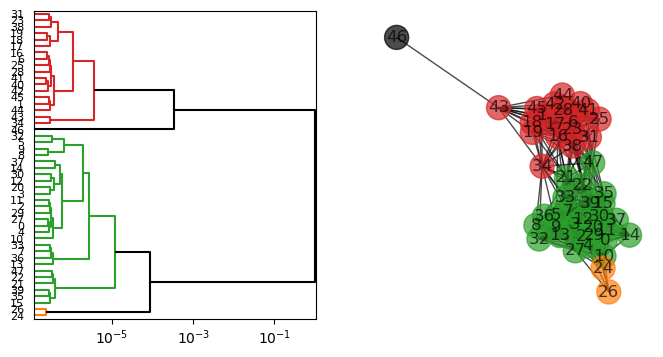

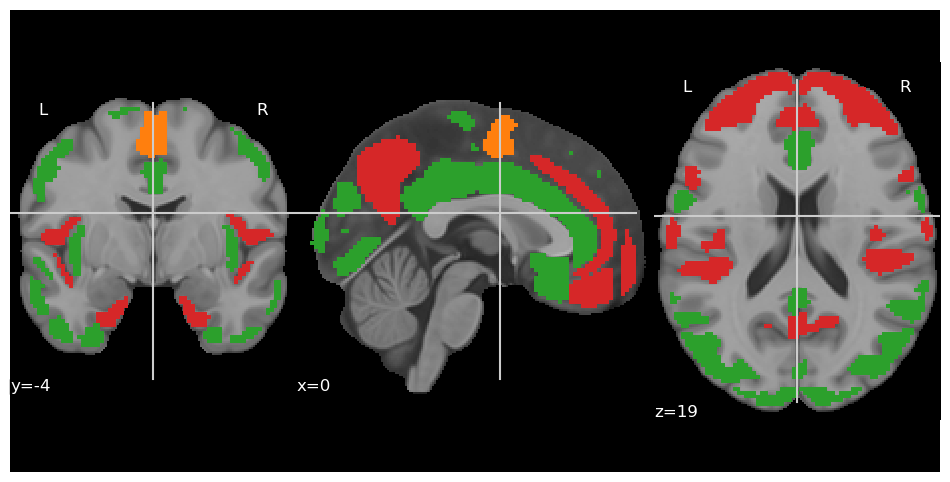

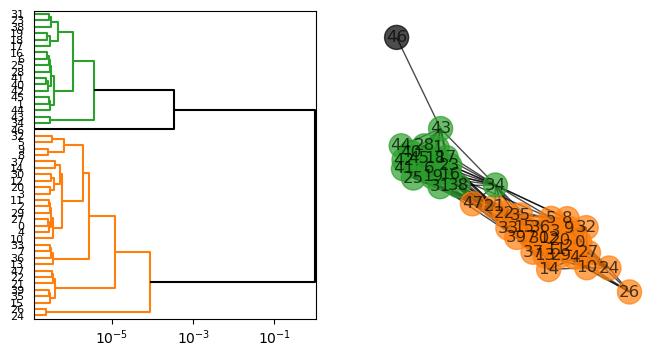

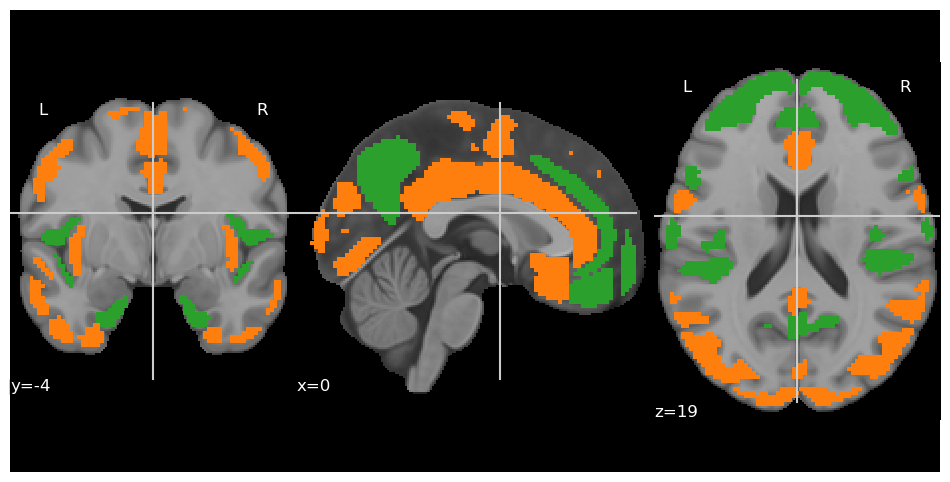

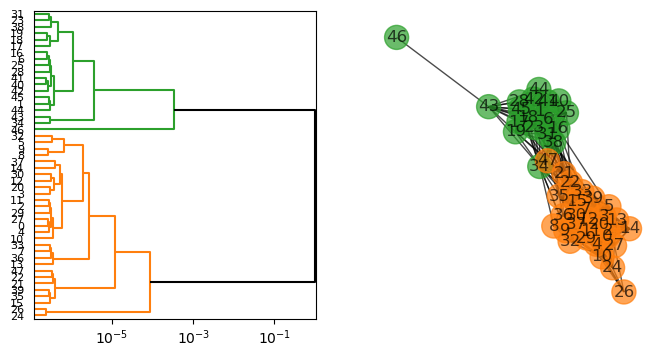

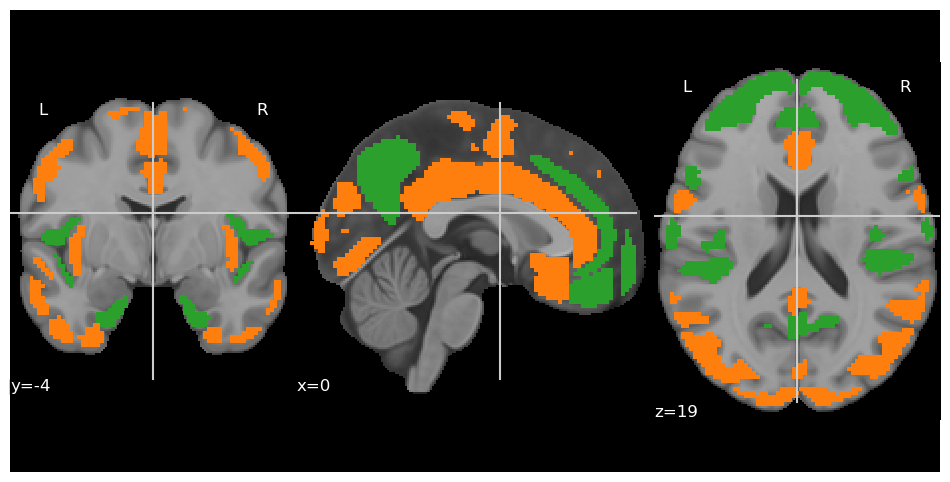

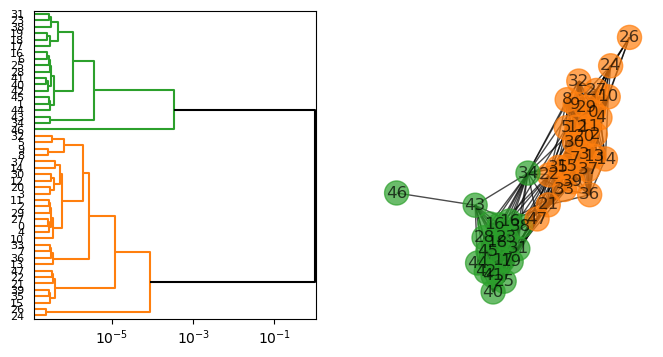

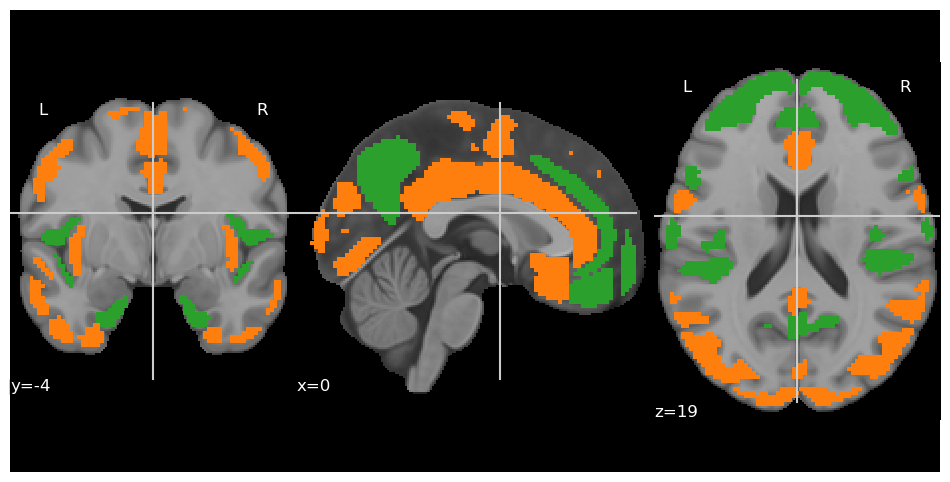

In [41]:
#
old_leaf_colors = {}
num_logpoint = 8
min_tau_exponent = int(min(np.log10(linkage_matrix[:,2]).astype(int)))
max_tau_exponent = int(np.log10(linkage_matrix[:,2]).astype(int)[-2])
for i, dendro_threshold in enumerate(np.logspace(min_tau_exponent, max_tau_exponent, num_logpoint)):
    try:
        old_leaf_colors
    except NameError:
        old_leaf_colors = {}
    optimal_clusters = fcluster(linkage_matrix, t=dendro_threshold, criterion='distance')
    #
    fig2, ax2 = plt.subplots(1, 2, figsize=(8, 4))
    dendro = dendrogram(linkage_matrix, ax=ax2[0],
                        color_threshold=dendro_threshold,
                        above_threshold_color='k',
                        orientation='right', labels=label_list)
    ax2[0].set_xscale('log')
    ax2[0].set_xlim(tmin)
    #
    # Update colors: keep the old color if the label exists; otherwise, use the new color.
    new_leaf_colors = {}
    for label, new_color in zip(dendro['ivl'], dendro['leaves_color_list']):
        if label in old_leaf_colors:
            new_leaf_colors[label] = old_leaf_colors[label]
        else:
            new_leaf_colors[label] = new_color

    leaf_label_colors = new_leaf_colors

    # Store colors for the next iteration.
    old_leaf_colors = new_leaf_colors.copy()
    #
    leaf_label_colors = {label: color for label, color in zip(dendro['ivl'], dendro['leaves_color_list'])}
    node_colors = [leaf_label_colors[label] for _,label in enumerate(label_list)]
    nx.draw(G, ax=ax2[1], node_color=node_colors, with_labels=True, alpha=0.7)
    fig2.savefig(path_neuroplots / f"dendrogram_{dk}_{i}_{dendro_threshold:.2e}.png", bbox_inches='tight')
    #
    fig, ax = plt.subplots(figsize=(12, 6))
    node_colors = [leaf_label_colors[i] if i in leaf_label_colors.keys() else 'white' for i in range(len(roi_indices))]
    cmap = ListedColormap(node_colors)
    plotting.plot_stat_map(atlas_img, bg_img=template, axes=ax, cmap=cmap, colorbar=False)
    fig.savefig(path_neuroplots / f"networkatlasmap_{dk}_{i}_{dendro_threshold:.2e}.png", bbox_inches='tight')
